# Multivariate logistic model : algorithm 1

**Question 1.** Question on the model: Check that the exponent measure VL satisfies the homogeneity property (Hint: you can compute $V_L(tx)$ $t >0$ $x\in \mathbb{R}^d_+$, and $\lim\limits_{x_k\rightarrow \infty, k\neq j} V_L((x_1\dots x_d))$ with $j = 1\dots d$ and $x_j =1$)

We show easily that $V(tx) = t^{-1}V(x)$.

**Question 2.** Questions on Step 1

a/ What is the support of the random vector $(T_1\dots T_d)$ ?

The normalization makes the $T_j$ for $j=1\dots d$ be between $0$ and $1$. So the support of the vector $T=(T_1\dots T_d)$ is defined on the $d-1$ simplex $$\Delta_{d-1}=\left\{x_j\in [0, 1],\ j=1\dots d, \sum^d_{j=1} x_j = 1\right\}.$$

b/ What is its law on this support ? (Give a brief argument)

For all $i=1\dots d$, $W_i \sim \Gamma(1, 1)$ and $\sum\limits_{\substack{k=1\\ k\neq i}}^d W_k \sim \Gamma(d-1, 1)$, so $T_i$ follows a Beta distribution whose density equals $f_{T_i}(x) = \frac{(1-x)^{d-2}}{\Beta(1, d - 1)} = (d - 1)(1-x)^{d-2}$.

**Question 3.** Questions on Step 2

a/ Calculate $p_{1,1}, p_{2,1}, p_{2,2}, p_{3,1}, p_{3,2}, p_{3,3}$.

$p_{11} = 1$

$p_{21} = 1 - \alpha$,  $p_{22} = \alpha$

$p_{31} = 1 - \frac{3}{2}\alpha + \frac{\alpha^2}{2}$,  $p_{32} = \frac{3}{2}\alpha - \frac{3}{2}\alpha^2$, $p_{33} = \alpha^2$



b/ The $k$ defined in step 2 is random (its value will depend on $U$
 value). What is its law ? (Just give the result)

The law of $k= \sum\limits^d_{j=1} \chi_{U > \sum\limits^j_{i=1}p_{di}}$ is $\mathbb{P}(k=m) = p_{dm}$ for all $m\in\{1\dots d\}$.

**Question 4.** Question on Step 3: Can you deduce the law of $Z$ ?

We know that $\mathbb{P}(Z \leq z) = \sum\limits_{i=1}^d\mathbb{P}(Z \leq z | k=i)\mathbb{P}(k=i) = \sum\limits_{i=1}^dp_{di}\Gamma(z | i, 1)$, with $z\mapsto\Gamma(z | i,1)$ being the cdf of a gamma distribution with the adequate paramaters.

In [2]:
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import copy
from scipy.special import gamma
from scipy.stats import gamma as gamma_rv
from scipy.stats import pareto
import pandas as pd


In [3]:
def step_1(d):
    """
    Generates the values T_1, ..., T_d as described in the pseudoalgorithm.

    Parameters:
    d (int): The dimension, i.e., the number of independent standard exponential variables.

    Returns:
    T (numpy array): A vector of T_i values.
    """
    # Step 1: Generate d independent standard exponential random variables W_1, ..., W_d
    W = np.random.exponential(scale=1.0, size=d)
    
    # Normalize each W_i by the sum of all W_i's to compute T_1, ..., T_d
    T = W / np.sum(W)
    
    return T

# Example usage:
# d = 5  # Choose the desired dimension
# T_values = step_1(d)
# print("T values:", T_values)

1. Try to sample $T$ random variables from the \texttt{step 1} function implemented in the\texttt{tp2.ipynb} file. Plot on the same graph histograms of the marginals of $T$. How do you interpret this graph ?

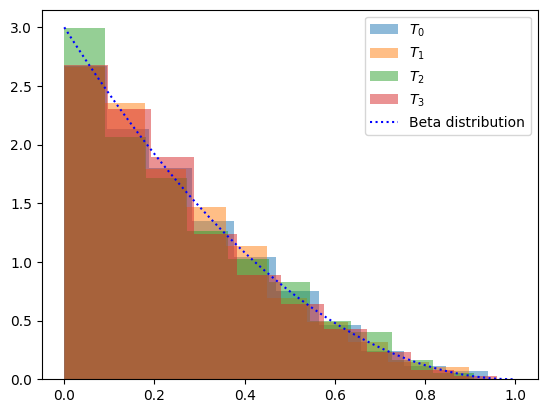

In [5]:

N = 2000
d = 4
samples = np.concatenate([[step_1(d)] for _ in range(N)]).reshape(N, d)
for i in range(d):
    plt.hist(samples[:,i], alpha=0.5, bins=10, density=True, label=f"$T_{i}$")
plt.plot(np.linspace(0, 1, 1000), (d-1)*(1 - np.linspace(0, 1, 1000))**(d-2), linestyle=":", color="blue", label="Beta distribution")
plt.legend()
plt.show()

2. Complete the \texttt{step 2} function in the \texttt{tp2.ipynb} file (Caution there is a typo in \cite{stephenson_mult}: use the recurrence relationship in \cite{shi_mult} or the corrected version of this TP).

In [7]:
def build_Pmatrix(d, alpha):
    P = np.zeros(shape=(d, d))
    P[0, 0] = 1
    for i in range(2, d + 1):
        P[i - 1, 0] = gamma(i - alpha) / (gamma(i) * gamma(1 - alpha))
        P[i - 1, i - 1] = alpha ** (i - 1)
        for j in range(2, i):
            P[i - 1, j - 1] = (
                (i - 1 - alpha * j) * P[i - 2, j - 1]
                + alpha * (j - 1) * P[i - 2, j - 2]
            ) / (i - 1)
    return P

def step_2(d, P):
    U = np.random.random()
    k = -1
    sum_P = 0
    while k < d - 1 or sum_P < U:
        k += 1
        sum_P += P[d - 1, k]
    return k + 1

3. Implement the algorithm to generate a sample of $n$ variables from the exponent measure, in dimension $d \in \mathbb{N}$, with $\alpha \in (0,1]$.

In [8]:
def sample_generation(n, d, alpha):
    P = build_Pmatrix(d, alpha)
    Zs = []
    for _ in range(n):
        T = step_1(d)
        k = step_2(d, P)
        Z = gamma_rv.rvs(a=k, scale=1)
        Zs.append(1 / (Z * T**alpha))
    return np.concatenate(Zs).reshape(n, d)

In [9]:
samples = sample_generation(100000, 4, 1/4)

4. Sample $(X_i)_{i = 1 \dots n}$ for a large $n$. Plot boxplots of the  angle of $X$ for a growing value of its norm. (You can make boxplots of the angles of the variables $X_i \mathbb{I}_{r\leq||X||<r+1}, r=1\dots 100$). How do you interpret this graph ?

In [10]:
norms = np.linalg.norm(samples, axis=1)
angles = []
for r in range(1, 101):
    angle = (samples / norms[:, np.newaxis])[(norms >= r) * (norms < r + 1), :].reshape(-1,)
    if len(angle) != 0:
        angles.append(angle)


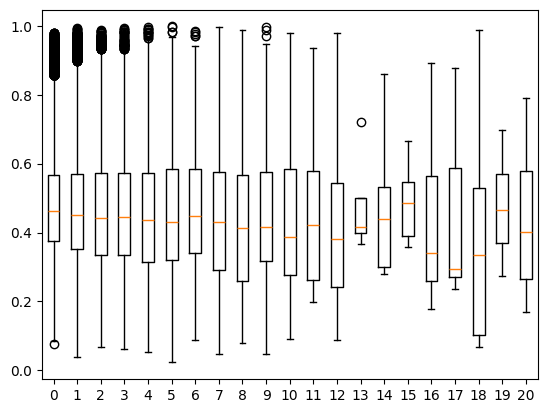

In [11]:
plt.boxplot(angles, positions=range(len(angles)))
plt.show()

We see that the distribution of angle is similar for different value of the norm of $X$. For high values of $r$, the number of sampled angle values is really limited thus it is difficult to evaluate accurately the distribution.

5. Set $d=2$ and compare the angle distribution (marginal and bivariate distribution) for $\alpha \rightarrow 0$ and for $\alpha \rightarrow 1$.

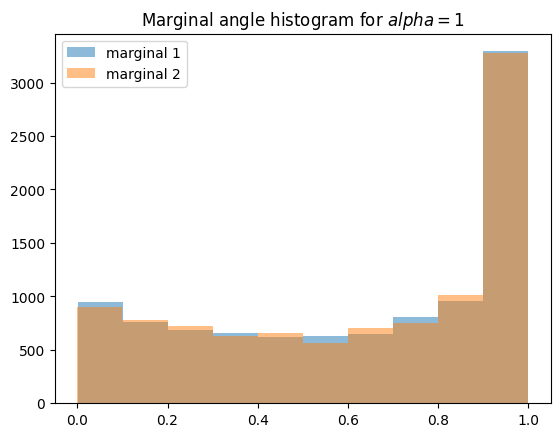

In [12]:
samples = sample_generation(10000, 2, 1)
angles1= samples / np.linalg.norm(samples, axis=1)[:, np.newaxis]

plt.hist(angles1[:, 0], alpha=0.5, label="marginal 1")
plt.hist(angles1[:, 1], alpha=0.5, label="marginal 2")
plt.title("Marginal angle histogram for $alpha = 1$")
plt.legend()
plt.show()

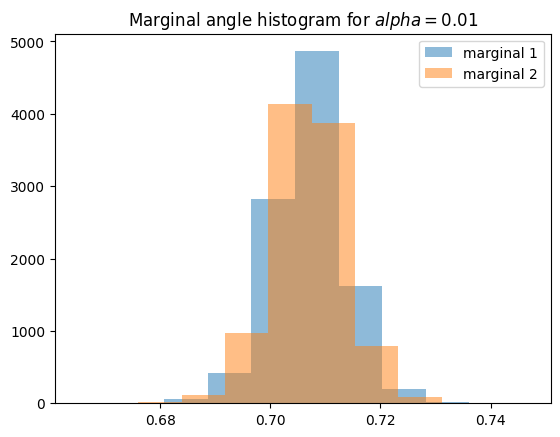

In [13]:
samples = sample_generation(10000, 2, 1e-2)
angles = samples / np.linalg.norm(samples, axis=1)[:, np.newaxis]

plt.hist(angles[:, 0], alpha=0.5, label="marginal 1")
plt.hist(angles[:, 1], alpha=0.5, label="marginal 2")
plt.title("Marginal angle histogram for $alpha = 0.01$")
plt.legend()
plt.show()

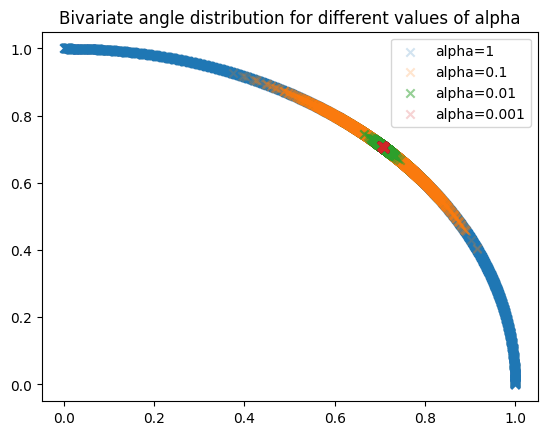

In [14]:
samplese1 = sample_generation(10000, 2, 1e-1)
anglese1 = samplese1 / np.linalg.norm(samplese1, axis=1)[:, np.newaxis]
samplese3 = sample_generation(10000, 2, 1e-3)
anglese3 = samplese3 / np.linalg.norm(samplese3, axis=1)[:, np.newaxis]
plt.scatter(angles1[:, 0], angles1[:, 1], label="alpha=1", alpha=0.2, marker="x")
plt.scatter(anglese1[:, 0], anglese1[:, 1], label="alpha=0.1", alpha=0.2, marker="x")
plt.scatter(angles[:, 0], angles[:, 1], label="alpha=0.01", alpha=0.5, marker="x")
plt.scatter(anglese3[:, 0], anglese3[:, 1], label="alpha=0.001", alpha=0.2, marker="x")
plt.title("Bivariate angle distribution for different values of alpha")
plt.legend()
plt.show()

Can you sample $X_1 \dots X_n, \quad n=10000$ variables from a chosen $\alpha$ and a chosen $d$ and fit a Fréchet distribution (with $0$ location and $1$ scale) to one of the coordinates (for example on $X_1^1 \dots X_n^1$) . For the fit you can use $\texttt{scipy.stats.invweibull.fit(data, , floc=0, fscale=1)}$ to make sure location and scale are not free parameters (because it can lead to unstable estimates). What $\gamma$ estimation do you get ? Is it consistant with theory ?

In [16]:
samples = sample_generation(10000, 4, 1/4)

from scipy.stats import invweibull

gamma_param, loc, scale = invweibull.fit(samples[:,0], floc=0, fscale=1)

In [19]:
1/(-1 - gamma_param)

np.float64(-0.5687624972228398)